# Self-Driving CNN model

## Base Model

In [16]:
# Read images and steering angles from driving_dataset folder
import os
import numpy as np
import random

from scipy import pi
from itertools import islice

DATA_FOLDER = '/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')

split = 0.8
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp,45407):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle)*pi/180)
        
y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.8)

train_y = y[:split_index]
test_y = y[split_index:]




Completed processing data.txt


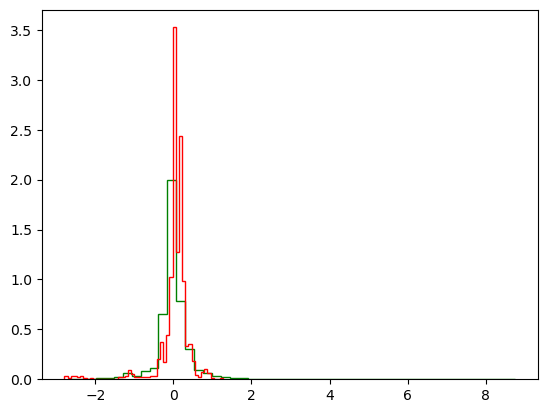

In [17]:
import numpy;
# PDF of train and test 'y' values

import matplotlib.pyplot as plt
plt.hist(train_y, bins=50, density=True, color='green', histtype ='step');
plt.hist(test_y, bins=50, density=True, color='red', histtype ='step');
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error,r2_score

# Calculate mean of train_y
train_mean_y = np.mean(train_y)
# Calculate R-squared for mean baseline prediction
r2_mean_baseline = r2_score(test_y, np.full_like(test_y, fill_value=train_mean_y))

# Calculate R-squared for zero baseline prediction
r2_zero_baseline = r2_score(test_y, np.zeros_like(test_y))

# Print R-squared values
print('R-squared (Mean Baseline): %.6f' % r2_mean_baseline)
print('R-squared (Zero Baseline): %.6f' % r2_zero_baseline)


R-squared (Mean Baseline): -0.002249
R-squared (Zero Baseline): -0.001012


## CNN Model Section

In [3]:
import os
from PIL import Image
import numpy as np

#Read data from data.txt file
data_file = '/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/data.txt'
image_dir = '/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/'  # Directory containing your images

#Rading the image name and label (steering angle) from teh text file
data = []
with open(data_file, 'r') as f:
    for line in f:
        image_name, label = line.strip().split()
        label = float(label)  # Convert label to float
        data.append((image_name, label))




In [4]:
#checking image size
test_img = Image.open('/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/45.jpg')
test_img.size

(455, 256)

In [5]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

# creating a custom dataset class to create train and test dataset
class CustomDataset(Dataset):
    def __init__(self, data, image_dir, transform=None, split='train', train_split_ratio=0.8, shuffle_data=True):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.split = split
        self.train_split_ratio = train_split_ratio
        self.shuffle_data = shuffle_data
        
        if self.shuffle_data:
            random.shuffle(self.data)  # Shuffle the data if specified
        
        if self.split == 'train':
            self.data = self.data[:int(len(self.data) * self.train_split_ratio)]
        elif self.split == 'val':
            self.data = self.data[int(len(self.data) * self.train_split_ratio):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

# Define your transformation on the image
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0/255, 1.0/255, 1.0/255])
])

# Create training and validation datasets
train_dataset = CustomDataset(data, image_dir, transform=transform, split='train')
val_dataset = CustomDataset(data, image_dir, transform=transform, split='val')

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)



In [6]:
total_images = len(val_dataset)
print(total_images)

9082


In [7]:
import torch as th
seed = 42
np.random.seed(seed)
th.manual_seed(seed)

#checking the availability of the cuda
if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Creating a VGG inspired custom CNN model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)        
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 50 * 50, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 128)
        self.relu6 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        
        # print("Shape after convolutional layers:", x.shape)
        
        # Flatten the tensor
        x = x.view(-1, 128 * 50 * 50)
        
        # Fully connected layers
        x = self.relu5(self.fc1(x))
        x = self.dropout(x)
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)
        
        return x.squeeze(1)


# Create an instance of MiniVGG16Regression
model = CustomVGG()


## Training the neural net for 30 and 50 epochs

In [41]:
# Move model to GPU
model.to(device)

# Initialize optimizer with model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
# num_epochs = 50
num_epochs = 50
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    epoch_training_loss = 0.0
    epoch_validation_loss = 0.0

    # Training
    model.train()
    for inputs, targets in train_dataloader:  # Use train_dataloader for training
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() * inputs.size(0)

    # Calculate average training loss for the epoch
    epoch_training_loss /= len(train_dataloader.dataset)
    training_losses.append(epoch_training_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:  # Use val_dataloader for validation
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)  # Move data to GPU
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            epoch_validation_loss += val_loss.item() * val_inputs.size(0)
    epoch_validation_loss /= len(val_dataloader.dataset)
    validation_losses.append(epoch_validation_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_training_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_validation_loss:.4f}")

Epoch [1/50], Training Loss: 50.2906
Epoch [1/50], Validation Loss: 166.5147
Epoch [2/50], Training Loss: 52.3373
Epoch [2/50], Validation Loss: 154.0984
Epoch [3/50], Training Loss: 52.6552
Epoch [3/50], Validation Loss: 154.6150
Epoch [4/50], Training Loss: 44.4567
Epoch [4/50], Validation Loss: 156.1306
Epoch [5/50], Training Loss: 50.6643
Epoch [5/50], Validation Loss: 159.5046
Epoch [6/50], Training Loss: 51.4967
Epoch [6/50], Validation Loss: 184.8207
Epoch [7/50], Training Loss: 46.1606
Epoch [7/50], Validation Loss: 140.7688
Epoch [8/50], Training Loss: 46.0693
Epoch [8/50], Validation Loss: 160.1127
Epoch [9/50], Training Loss: 40.3192
Epoch [9/50], Validation Loss: 195.5295
Epoch [10/50], Training Loss: 44.3162
Epoch [10/50], Validation Loss: 235.2044
Epoch [11/50], Training Loss: 43.7509
Epoch [11/50], Validation Loss: 122.7800
Epoch [12/50], Training Loss: 40.3629
Epoch [12/50], Validation Loss: 163.0208
Epoch [13/50], Training Loss: 38.6252
Epoch [13/50], Validation Loss: 

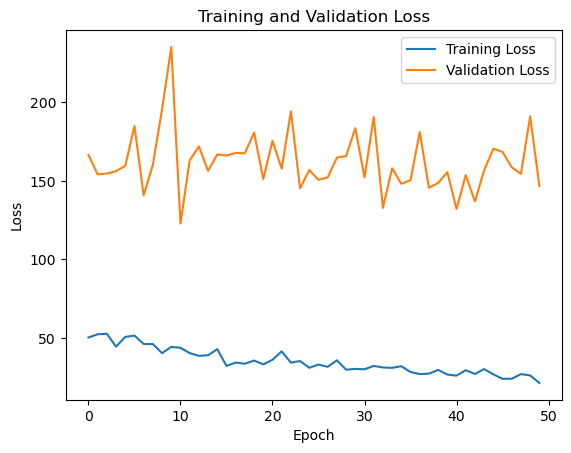

In [43]:
import matplotlib.pyplot as plt
# Plotting
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Saving the model weights after training

In [42]:
import torch as th
model_path = '/home/exouser/ME592_course_project_TG2/model/model50.pth'
th.save(model.state_dict(),model_path)

## Loading the saved model for pediction

In [9]:
import torch as th
model_path = '/home/exouser/ME592_course_project_TG2/model/model50.pth'
model.load_state_dict(th.load(model_path))
# Move model to GPU
model.to(device)
model.eval()

CustomVGG(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_feat

## This piece of code predcits the steering angel and vidualises it using CV2

In [ ]:
import cv2
import math
from PIL import Image

DATA_FOLDER = '/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

xs = []
ys = []
with open(TRAIN_FILE) as f:
    for line in f:
        xs.append(DATA_FOLDER + line.split()[0])
        ys.append(float(line.split()[1]))

num_images = len(xs)
i = math.ceil(num_images * 0.5)

while cv2.waitKey(10) != ord('q'):
    full_image = cv2.imread(DATA_FOLDER + str(i) + ".jpg")
    image = Image.open(DATA_FOLDER + str(i) + ".jpg")    
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        degrees = output.item()
    
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow("frame", full_image)
    
    # Update visualization of steering wheel
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -smoothed_angle, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    cv2.imshow("steering wheel", dst)
    
    i += 1

cv2.destroyAllWindows()


In [10]:
import cv2
import math
from PIL import Image
import os

DATA_FOLDER = '/home/exouser/Downloads/Project_code_data/Dataset/driving_dataset/driving_dataset/'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0



xs = []
ys = []
with open(TRAIN_FILE) as f:
    for line in f:
        xs.append(DATA_FOLDER + line.split()[0])
        ys.append(float(line.split()[1]))

num_images = len(xs)
i = math.ceil(num_images * 0.8)
# Initialize lists to store predicted and actual steering angles
predicted_angles = []
actual_angles = []

# Iterate through the data and make predictions
while cv2.waitKey(10) != ord('q'):
    full_image = cv2.imread(os.path.join(DATA_FOLDER, str(i) + ".jpg"))
    image = Image.open(os.path.join(DATA_FOLDER, str(i) + ".jpg"))
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        degrees = output.item()
    
    # Store predicted and actual steering angles
    predicted_angles.append(degrees)
    actual_angles.append(ys[i])
    i += 1
    # print("Predicted steering angle: " + str(degrees) + " degrees")
    # cv2.imshow("frame", full_image)

IndexError: list index out of range

## Plotting the predicted vs actual values plot

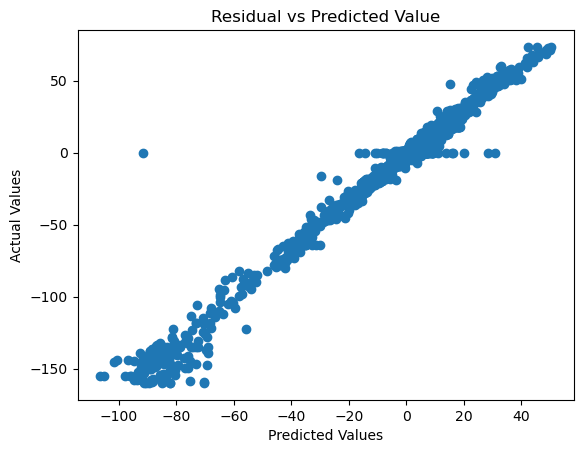

In [39]:
import matplotlib.pyplot as plt
# Compute residuals
# residuals = np.array(actual_angles) - np.array(predicted_angles)

# Plot residual vs predicted value scatter plot
plt.scatter(predicted_angles[:9081], actual_angles[:9081])
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Residual vs Predicted Value")
plt.show()

## Calculating the R^2 and MSE values

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R-squared
r_squared = r2_score(actual_angles[:9081], predicted_angles[:9081])
print("R-squared:", r_squared)


R-squared: 0.8362093975600626
